In [50]:
import yfinance as yf
import pandas_datareader.data as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from ta import add_all_ta_features # A library for technical analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set plot style
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [52]:
# Define tickers and date range
sp500_ticker = '^GSPC'
fred_tickers = ['FEDFUNDS', 'CPIAUCNS'] # Federal Funds Rate, Consumer Price Index
start_date = '2010-01-01'
end_date = '2025-09-12'

# Fetch S&P 500 data
if (os.path.exists('sp500_ticker_indexed.csv')):
    df = pd.read_csv('sp500_ticker_indexed.csv')
else:
    df = yf.download(sp500_ticker, start=start_date, end=end_date)
    df.to_csv('sp500_ticker_indexed.csv')

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(0)

print(df.head())
print(df.shape)

# Fetch Macroeconomic data from FRED
if (os.path.exists('fred_tickers_indexed.csv')):
    macro_data = pd.read_csv('fred_tickers_indexed.csv')
else:
    macro_data = pdr.DataReader(fred_tickers, 'fred', start=start_date, end=end_date)
    macro_data.to_csv('fred_tickers_indexed.csv')

print(macro_data.head())
print(macro_data.shape)

        Price               Close                High                 Low  \
0      Ticker               ^GSPC               ^GSPC               ^GSPC   
1        Date                 NaN                 NaN                 NaN   
2  2010-01-04   1132.989990234375  1133.8699951171875    1116.56005859375   
3  2010-01-05    1136.52001953125  1136.6300048828125  1129.6600341796875   
4  2010-01-06  1137.1400146484375    1139.18994140625   1133.949951171875   

                 Open      Volume  
0               ^GSPC       ^GSPC  
1                 NaN         NaN  
2    1116.56005859375  3991400000  
3  1132.6600341796875  2491020000  
4     1135.7099609375  4972660000  
(3949, 6)
         DATE  FEDFUNDS  CPIAUCNS
0  2010-01-01      0.11   216.687
1  2010-02-01      0.13   216.741
2  2010-03-01      0.16   217.631
3  2010-04-01      0.20   218.009
4  2010-05-01      0.20   218.178
(189, 3)


In [54]:
df1 = df.copy(deep = True)
df2 = macro_data.copy(deep = True)

# --- Step 1: Clean and prepare the first DataFrame ---
df1 = df1.drop([0, 1])     # Drop header rows
df1 = df1.rename(columns={'Price': 'Date'})  # Match column name for merge
df1['Date'] = pd.to_datetime(df1['Date'])   # Convert to datetime
print(df1.head())

        Date               Close                High                 Low  \
2 2010-01-04   1132.989990234375  1133.8699951171875    1116.56005859375   
3 2010-01-05    1136.52001953125  1136.6300048828125  1129.6600341796875   
4 2010-01-06  1137.1400146484375    1139.18994140625   1133.949951171875   
5 2010-01-07    1141.68994140625     1142.4599609375  1131.3199462890625   
6 2010-01-08    1144.97998046875  1145.3900146484375   1136.219970703125   

                 Open      Volume  
2    1116.56005859375  3991400000  
3  1132.6600341796875  2491020000  
4     1135.7099609375  4972660000  
5    1136.27001953125  5270680000  
6    1140.52001953125  4389590000  


In [56]:
# --- Step 2: Prepare the second DataFrame ---
df2 = df2.rename(columns={'DATE':'Date'})
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.set_index('Date').resample('D').ffill().bfill().reset_index()  # Forward-fill/backward-fill daily

# --- Step 3: Merge the two DataFrames ---
merged_df = pd.merge(df1, df2, on='Date', how='left')

print(merged_df.head())
print(merged_df.tail())
print(merged_df.describe())

        Date               Close                High                 Low  \
0 2010-01-04   1132.989990234375  1133.8699951171875    1116.56005859375   
1 2010-01-05    1136.52001953125  1136.6300048828125  1129.6600341796875   
2 2010-01-06  1137.1400146484375    1139.18994140625   1133.949951171875   
3 2010-01-07    1141.68994140625     1142.4599609375  1131.3199462890625   
4 2010-01-08    1144.97998046875  1145.3900146484375   1136.219970703125   

                 Open      Volume  FEDFUNDS  CPIAUCNS  
0    1116.56005859375  3991400000      0.11   216.687  
1  1132.6600341796875  2491020000      0.11   216.687  
2     1135.7099609375  4972660000      0.11   216.687  
3    1136.27001953125  5270680000      0.11   216.687  
4    1140.52001953125  4389590000      0.11   216.687  
           Date             Close              High               Low  \
3942 2025-09-05            6481.5  6532.64990234375  6443.97998046875   
3943 2025-09-08  6495.14990234375    6508.669921875   6483.29

In [58]:
# --- 1. Create Target Variable ---
df = merged_df.copy(deep = True)
# We want to predict if the next day's price will go up (1) or down (0)
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
print(df.head())
df.info

        Date               Close                High                 Low  \
0 2010-01-04   1132.989990234375  1133.8699951171875    1116.56005859375   
1 2010-01-05    1136.52001953125  1136.6300048828125  1129.6600341796875   
2 2010-01-06  1137.1400146484375    1139.18994140625   1133.949951171875   
3 2010-01-07    1141.68994140625     1142.4599609375  1131.3199462890625   
4 2010-01-08    1144.97998046875  1145.3900146484375   1136.219970703125   

                 Open      Volume  FEDFUNDS  CPIAUCNS  Target  
0    1116.56005859375  3991400000      0.11   216.687       1  
1  1132.6600341796875  2491020000      0.11   216.687       1  
2     1135.7099609375  4972660000      0.11   216.687       1  
3    1136.27001953125  5270680000      0.11   216.687       1  
4    1140.52001953125  4389590000      0.11   216.687       1  


<bound method DataFrame.info of            Date               Close                High                 Low  \
0    2010-01-04   1132.989990234375  1133.8699951171875    1116.56005859375   
1    2010-01-05    1136.52001953125  1136.6300048828125  1129.6600341796875   
2    2010-01-06  1137.1400146484375    1139.18994140625   1133.949951171875   
3    2010-01-07    1141.68994140625     1142.4599609375  1131.3199462890625   
4    2010-01-08    1144.97998046875  1145.3900146484375   1136.219970703125   
...         ...                 ...                 ...                 ...   
3942 2025-09-05              6481.5    6532.64990234375    6443.97998046875   
3943 2025-09-08    6495.14990234375      6508.669921875     6483.2900390625   
3944 2025-09-09    6512.60986328125    6518.22998046875      6483.080078125   
3945 2025-09-10     6532.0400390625    6555.97021484375       6516.33984375   
3946 2025-09-11    6587.47021484375    6592.89013671875     6545.7998046875   

                   

In [60]:
# List of columns to convert
cols_to_numeric = ['Open', 'High', 'Low', 'Close', 'Volume']

# Loop through the columns and convert them to numeric
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [62]:
df.info

<bound method DataFrame.info of            Date        Close         High          Low         Open  \
0    2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059   
1    2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034   
2    2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961   
3    2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020   
4    2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020   
...         ...          ...          ...          ...          ...   
3942 2025-09-05  6481.500000  6532.649902  6443.979980  6529.080078   
3943 2025-09-08  6495.149902  6508.669922  6483.290039  6498.089844   
3944 2025-09-09  6512.609863  6518.229980  6483.080078  6503.330078   
3945 2025-09-10  6532.040039  6555.970215  6516.339844  6550.290039   
3946 2025-09-11  6587.470215  6592.890137  6545.799805  6554.410156   

          Volume  FEDFUNDS  CPIAUCNS  Target  
0     3991400000      0.11   216.687       1  
1     2491020000     

In [64]:
# --- 2. Create Technical Indicators ---
df = add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
)

In [65]:
# --- 3. Final Cleanup ---
# Drop columns that are not useful
df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)

# Drop the last row as it will have a NaN in the 'Target' column
df.dropna(inplace=True)

print("Features engineered. New shape:", df.shape)
df.head()

Features engineered. New shape: (3939, 91)


,Date,Close,FEDFUNDS,CPIAUCNS,Target,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,2010-01-04,1132.989990,0.11,216.687,1,3.585569e+09,3991400000,0.898324,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1132.989990,0.000000,0.000000,0.000000
1,2010-01-05,1136.520020,0.11,216.687,1,5.997973e+09,6482420000,0.925268,8.793374e+09,2.218843,...,0.024849,0.004970,0.019879,-3.084546,-0.616909,-2.467637,1134.489945,0.311568,0.311083,0.311568
2,2010-01-06,1137.140015,0.11,216.687,1,7.079943e+09,11455080000,0.618061,7.977609e+09,0.360905,...,0.048386,0.013653,0.034733,-0.356759,-0.564879,0.208120,1135.598551,0.054552,0.054537,0.366290
3,2010-01-07,1141.689941,0.11,216.687,1,1.162198e+10,16725760000,0.694855,1.026384e+10,0.067636,...,0.098248,0.030572,0.067676,2.279443,0.003985,2.275457,1138.167455,0.400120,0.399322,0.767875
4,2010-01-08,1144.979980,0.11,216.687,1,1.561902e+10,21115350000,0.739700,1.086071e+10,0.817869,...,0.159242,0.056306,0.102936,2.564702,0.516129,2.048574,1141.086801,0.288173,0.287758,1.058261


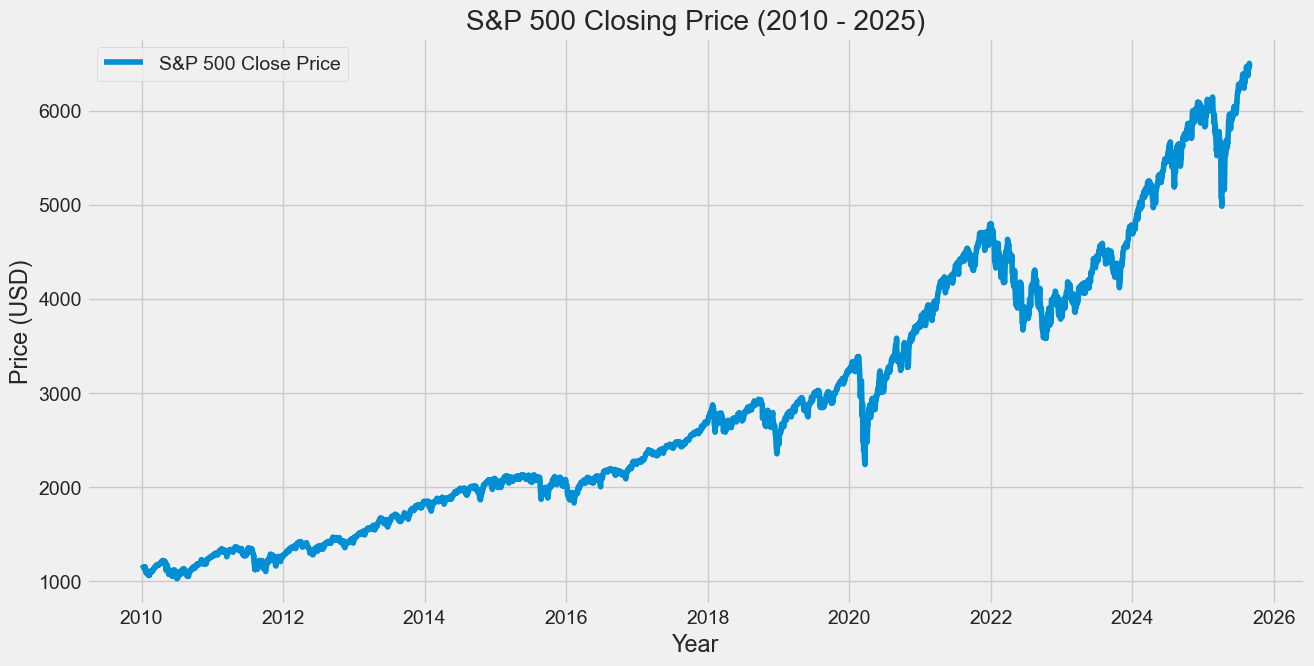

<Figure size 640x480 with 0 Axes>

In [68]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='S&P 500 Close Price')
plt.title('S&P 500 Closing Price (2010 - 2025)')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
plt.savefig('SP500_Closing_Price.png')

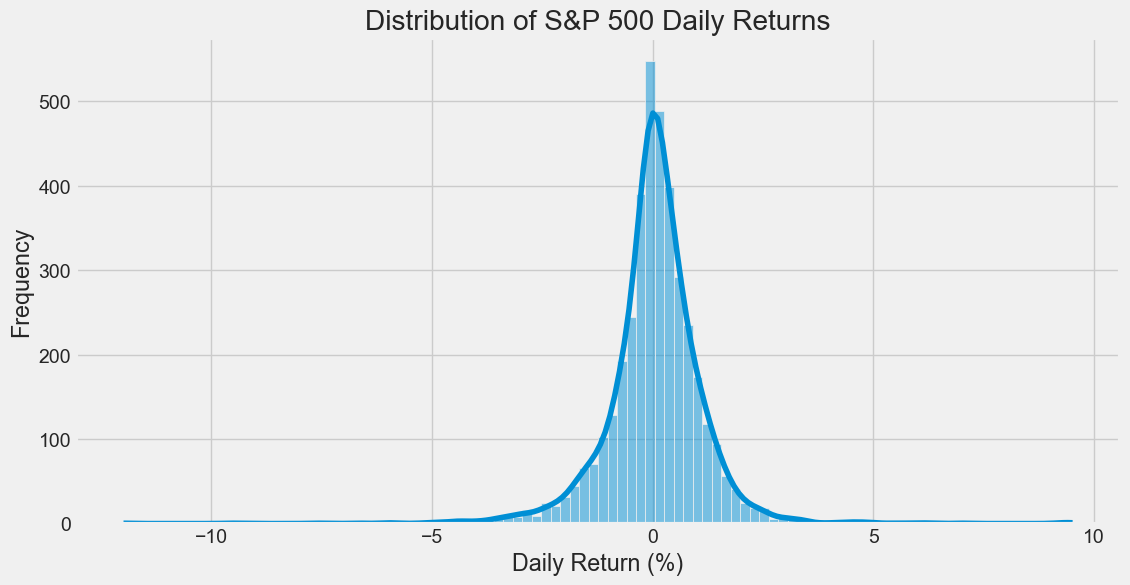

<Figure size 640x480 with 0 Axes>

In [70]:
df['Daily_Return'] = df['Close'].pct_change() * 100
df.dropna(inplace=True)

plt.figure(figsize=(12, 6))
sns.histplot(df['Daily_Return'], bins=100, kde=True)
plt.title('Distribution of S&P 500 Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.show()
plt.savefig('Distribution.png')

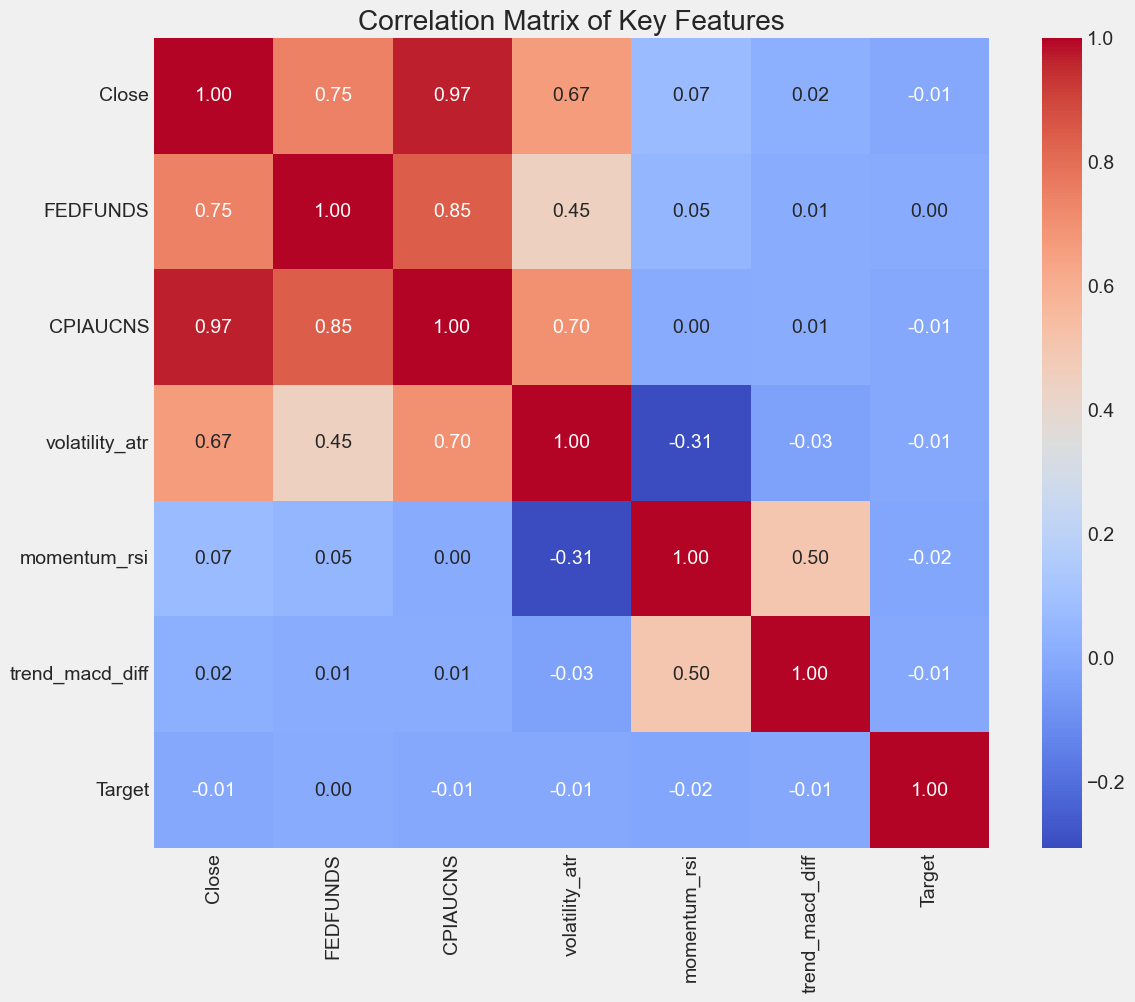

<Figure size 640x480 with 0 Axes>

In [72]:
# Select a subset of key features for a cleaner heatmap
features_for_corr = [
    'Close', 'FEDFUNDS', 'CPIAUCNS', 'volatility_atr',
    'momentum_rsi', 'trend_macd_diff', 'Target'
]

plt.figure(figsize=(12, 10))
sns.heatmap(df[features_for_corr].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Features')
plt.show()
plt.savefig('Correlation_Matrix.png')

In [74]:
# Make sure the main DataFrame's index is the date
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

features = df.drop(['Target', 'Close', 'Daily_Return'], axis=1)
target = df['Target']

# --- 2. Chronological Data Split ---
print("Splitting data...")
split_date = '2023-01-01'

X_train = features.loc[features.index < split_date]
X_test = features.loc[features.index >= split_date]
y_train = target.loc[target.index < split_date]
y_test = target.loc[target.index >= split_date]

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# --- 3. Scale the Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 4. Train and Evaluate the Model ---
model = LogisticRegression(random_state=42, max_iter = 1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nBaseline Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))

Splitting data...
Training set size: 3271 samples
Test set size: 667 samples

Baseline Model Accuracy: 0.4453

Classification Report:
              precision    recall  f1-score   support

        Down       0.44      0.98      0.61       294
          Up       0.60      0.02      0.05       373

    accuracy                           0.45       667
   macro avg       0.52      0.50      0.33       667
weighted avg       0.53      0.45      0.29       667



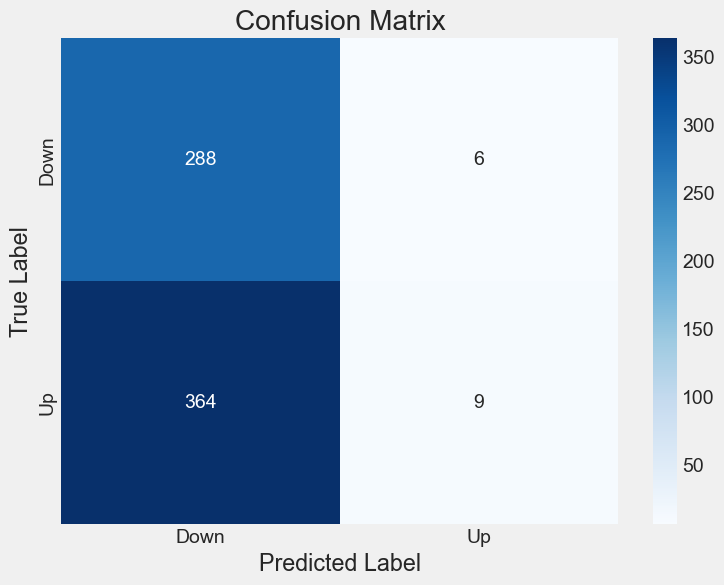

<Figure size 640x480 with 0 Axes>

In [76]:
# --- 6. Visualize the Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.savefig('Confustion_Matrix_2.png')